In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import multiprocessing
from joblib import Parallel, delayed
from psiam_utils import rho_A_t_fn, rho_E_t_fn, cum_A_t_fn, rho_E_minus_t_fn, P_large_t_btn_1_2, rho_E_minus_t_NORM_fn
from scipy.integrate import quad
import os
from pyvbmc import  VBMC
from scipy import stats
import corner


# Read data

In [2]:
with open('psiam_data_5k_6.pkl', 'rb') as f:
    psiam_data = pickle.load(f)


choices = psiam_data['choices']
RTs = psiam_data['RTs']
is_act_resp = psiam_data['is_act_resp']
V_A = psiam_data['V_A']
theta_A = psiam_data['theta_A']
V_E = psiam_data['V_E']
theta_E = psiam_data['theta_E']
Z_E = psiam_data['Z_E']
t_stim = psiam_data['t_stim']


indices_evid = np.where(is_act_resp == 0)[0]
RTs_evid = RTs[indices_evid].flatten()

indices_act = np.where(is_act_resp == 1)[0]
RTs_act = RTs[indices_act].flatten()


RTs = RTs.flatten()

correct_idx = np.where(choices == 1)[0]
wrong_idx = np.where(choices == -1)[0]
non_abort_idx = np.where(RTs >= t_stim)[0]

correct_non_abort_idx = np.intersect1d(correct_idx, non_abort_idx)
wrong_non_abort_idx = np.intersect1d(wrong_idx, non_abort_idx)

correct_RT = RTs[correct_non_abort_idx]
wrong_RT = RTs[wrong_non_abort_idx]

abort_idx = np.where(RTs < t_stim)[0]
abort_RT = RTs[abort_idx]

print(f"V_A: {V_A}")
print(f"theta_A: {theta_A}")
print(f"V_E: {V_E}")
print(f"theta_E: {theta_E}")
print(f"Num of AI process: {is_act_resp.sum()}/{len(is_act_resp)}")
print(f"Num of aborts : {len(abort_RT)}")
print(f"t start is {t_stim}")

V_A: 1
theta_A: 2
V_E: 1.2
theta_E: 2
Num of AI process: 5945/10000
Num of aborts : 270
t start is 0.5


In [9]:
def calculate_abort_loglike(t, V_A, theta_A, t_a, abort_norm_term):
    P_A = rho_A_t_fn(t, V_A, theta_A, t_a)
    # p_abort = (P_A * (1 - C_E) + P_E * (1 - C_A))/abort_norm_term
    # Since, C_E = 0 and P_E = 0
    p_abort = P_A/abort_norm_term
    if p_abort <= 0 or np.isnan(p_abort):
        p_abort = 1e-6
    return np.log(p_abort)

def calculate_correct_loglike(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, correct_norm_term):
    P_A = rho_A_t_fn(t, V_A, theta_A, t_a)
    P_E_btn_1_2 = P_large_t_btn_1_2(1, 2, t, V_E, theta_E, Z, K_max, t_stim)
    P_E_plus = rho_E_minus_t_NORM_fn(t, -V_E, theta_E, K_max, t_stim, -Z, t_E)
    C_A = cum_A_t_fn(t, V_A, theta_A, t_a)
    p_correct = (P_A * P_E_btn_1_2 + P_E_plus * (1 - C_A))/correct_norm_term
    if p_correct <= 0 or np.isnan(p_correct):
        p_correct = 1e-6
    return np.log(p_correct)

def calculate_wrong_loglike(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, wrong_norm_term):
    P_A = rho_A_t_fn(t, V_A, theta_A, t_a)
    P_E_btn_0_1 = P_large_t_btn_1_2(0, 1, t, V_E, theta_E, Z, K_max, t_stim)
    P_E_minus = rho_E_minus_t_NORM_fn(t, V_E, theta_E, K_max, t_stim, Z, t_E)
    C_A = cum_A_t_fn(t, V_A, theta_A, t_a)
    p_wrong = (P_A * P_E_btn_0_1 + P_E_minus * (1 - C_A))/wrong_norm_term
    if p_wrong <= 0 or np.isnan(p_wrong):
        p_wrong = 1e-6
    return np.log(p_wrong)



def psiam_loglike_fn(params):
    V_A, theta_A, V_E, theta_E, Z = params
    # hyperparams
    t_a = 0; t_E = 0; 
    K_max = int(30)
    
    abort_norm_term = 1; correct_norm_term = 1; wrong_norm_term = 1; n_jobs=-1

    abort_loglike = sum(Parallel(n_jobs=n_jobs)(
        delayed(calculate_abort_loglike)(t, V_A, theta_A, t_a, abort_norm_term)
        for t in abort_RT
    ))
    
    correct_loglike = sum(Parallel(n_jobs=n_jobs)(
        delayed(calculate_correct_loglike)(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, correct_norm_term)
        for t in correct_RT
    ))
    
    wrong_loglike = sum(Parallel(n_jobs=n_jobs)(
        delayed(calculate_wrong_loglike)(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, wrong_norm_term)
        for t in wrong_RT
    ))
    
    total_loglike = abort_loglike + correct_loglike + wrong_loglike


    if np.isnan(total_loglike):
        raise ValueError("Log-likelihood is NaN or infinite.")
    if np.isinf(total_loglike):
        raise ValueError("Log-likelihood is infinite.")

    return total_loglike

    

In [10]:
# Bounds
# V_A: 1 # theta_A: 2 # V_E: 0.5 # theta_E: 1 # Z = 0

V_A_bounds = [0.1, 2]; V_A_plausible_bounds = [0.5, 1.5]
theta_A_bounds = [1, 3]; theta_A_plausible_bounds = [1.5, 2.5]
V_E_bounds = [-2, 2]; V_E_plausible_bounds = [-1, 1]
theta_E_bounds = [0.1, 3]; theta_E_plausible_bounds = [0.5,1.5]
Z_bounds = [-0.5, 0.5]; Z_plausible_bounds = [-0.2, 0.2]

# V_A_bounds = [0.5, 1.5]; V_A_plausible_bounds = [0.7, 1.3]
# theta_A_bounds = [1.5, 2.5]; theta_A_plausible_bounds = [1.7, 2.2]
# V_E_bounds = [0, 1]; V_E_plausible_bounds = [0.2, 0.7]
# theta_E_bounds = [0.1, 2]; theta_E_plausible_bounds = [0.5,1.5]
# Z_bounds = [-0.2, 0.2]; Z_plausible_bounds = [-0.1, 0.1]

def psiam_log_prior_fn(params):
    V_A, theta_A, V_E, theta_E, Z = params

    # declare distributions
    V_A_prior = stats.uniform(loc=V_A_bounds[0], scale=V_A_bounds[1] - V_A_bounds[0])
    theta_A_prior = stats.uniform(loc=theta_A_bounds[0], scale=theta_A_bounds[1] - theta_A_bounds[0])
    V_E_prior = stats.uniform(loc=V_E_bounds[0], scale=V_E_bounds[1] - V_E_bounds[0])
    theta_E_prior = stats.uniform(loc=theta_E_bounds[0], scale=theta_E_bounds[1] - theta_E_bounds[0])
    Z_prior = stats.uniform(loc=Z_bounds[0], scale=Z_bounds[1] - Z_bounds[0])


    # PDF
    log_prior_V_A = V_A_prior.logpdf(V_A)
    log_prior_theta_A = theta_A_prior.logpdf(theta_A)
    log_prior_V_E = V_E_prior.logpdf(V_E)
    log_prior_theta_E = theta_E_prior.logpdf(theta_E)
    log_prior_Z = Z_prior.logpdf(Z)


    sum_log_priors = log_prior_V_A + log_prior_theta_A + log_prior_V_E + log_prior_theta_E + log_prior_Z
    return sum_log_priors

In [11]:
def log_joint(params):
    loglike = psiam_loglike_fn(params)
    logprior = psiam_log_prior_fn(params)
    prior_plus_loglike = loglike + logprior
    return prior_plus_loglike

In [12]:
lb = np.array([V_A_bounds[0], theta_A_bounds[0], V_E_bounds[0], theta_E_bounds[0], Z_bounds[0]])
ub = np.array([V_A_bounds[1], theta_A_bounds[1], V_E_bounds[1], theta_E_bounds[1], Z_bounds[1]])
plb = np.array([V_A_plausible_bounds[0], theta_A_plausible_bounds[0], V_E_plausible_bounds[0], theta_E_plausible_bounds[0], Z_plausible_bounds[0]])
pub = np.array([V_A_plausible_bounds[1], theta_A_plausible_bounds[1], V_E_plausible_bounds[1], theta_E_plausible_bounds[1], Z_plausible_bounds[1]])


V_A_0 = np.random.uniform(plb[0], pub[0])
theta_A_0 =  np.random.uniform(plb[1], pub[1])
V_E_0 = np.random.uniform(plb[2], pub[2])
theta_E_0 = np.random.uniform(plb[3], pub[3])
Z_0 = np.random.uniform(plb[4], pub[4])

x0 = np.array([V_A_0, theta_A_0, V_E_0, theta_E_0, Z_0]);

vbmc = VBMC(log_joint, x0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 5).
Reshaping upper bounds to (1, 5).
Reshaping plausible lower bounds to (1, 5).
Reshaping plausible upper bounds to (1, 5).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -12295.097 +/-0.001.


In [13]:
vp_samples, _ = vp.sample(int(1e5))
V_A_samp = vp_samples[:,0]; theta_A_samp = vp_samples[:,1]
V_E_samp = vp_samples[:,2]; theta_E_samp = vp_samples[:,3]
Z_samp =  vp_samples[:,4]

combined_samples_vb = np.transpose(np.vstack((V_A_samp, theta_A_samp, V_E_samp, theta_E_samp, Z_samp)))
param_labels = ['V_A', 'theta_A', 'V_E', 'theta_E', 'Z']
true_arr = [V_A, theta_A, V_E, theta_E, Z_E]

In [12]:
range=[V_A_plausible_bounds, theta_A_plausible_bounds, V_E_plausible_bounds, theta_E_plausible_bounds, Z_plausible_bounds]

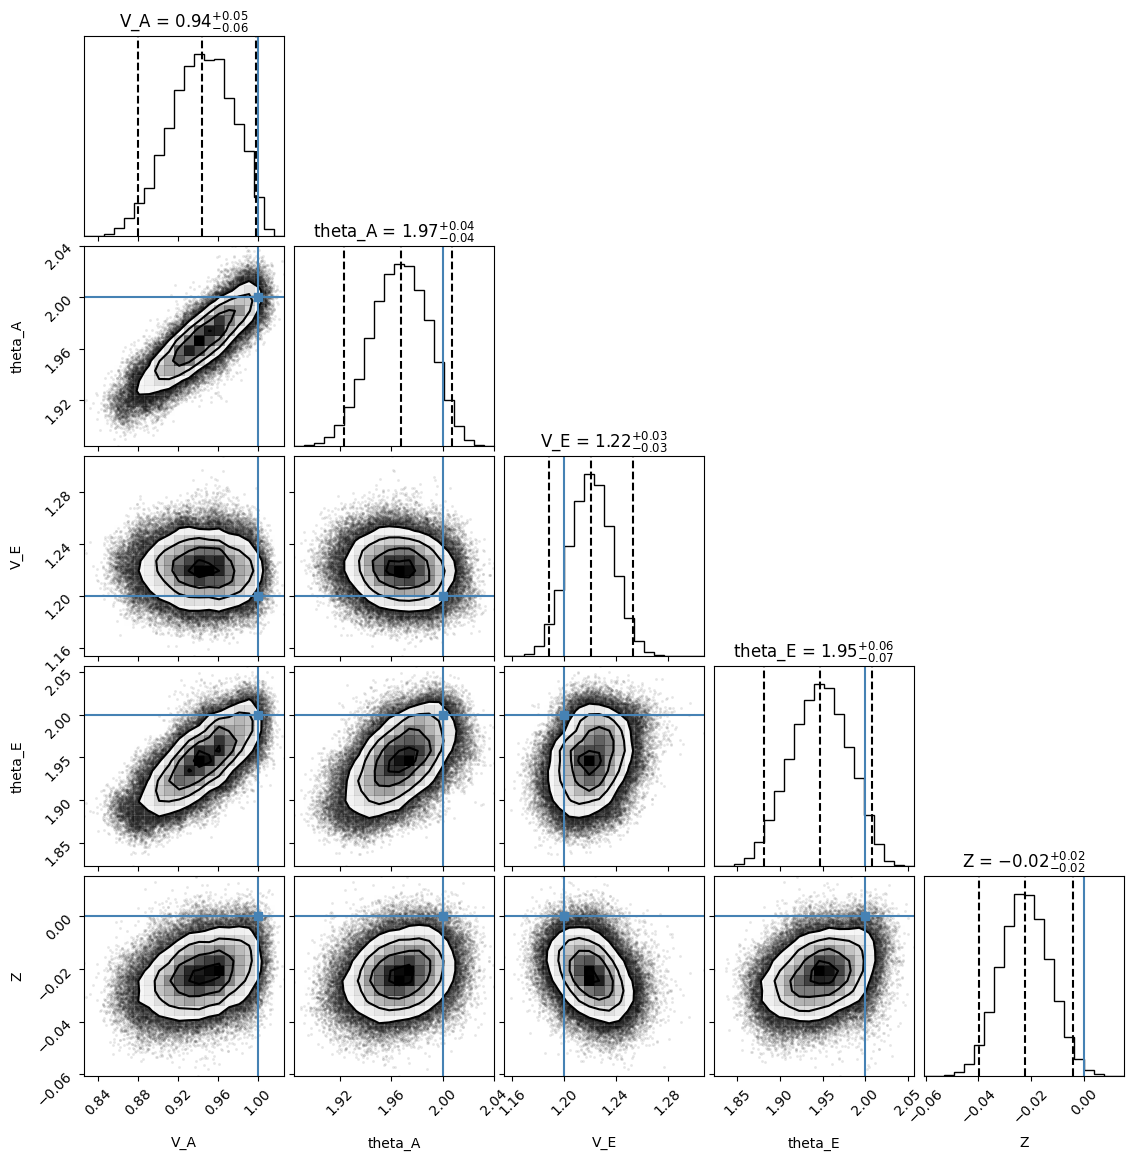

In [14]:
corner.corner(combined_samples_vb, labels=param_labels, show_titles=True, quantiles=[0.025, 0.5, 0.975], truths=true_arr); # range=corner_span

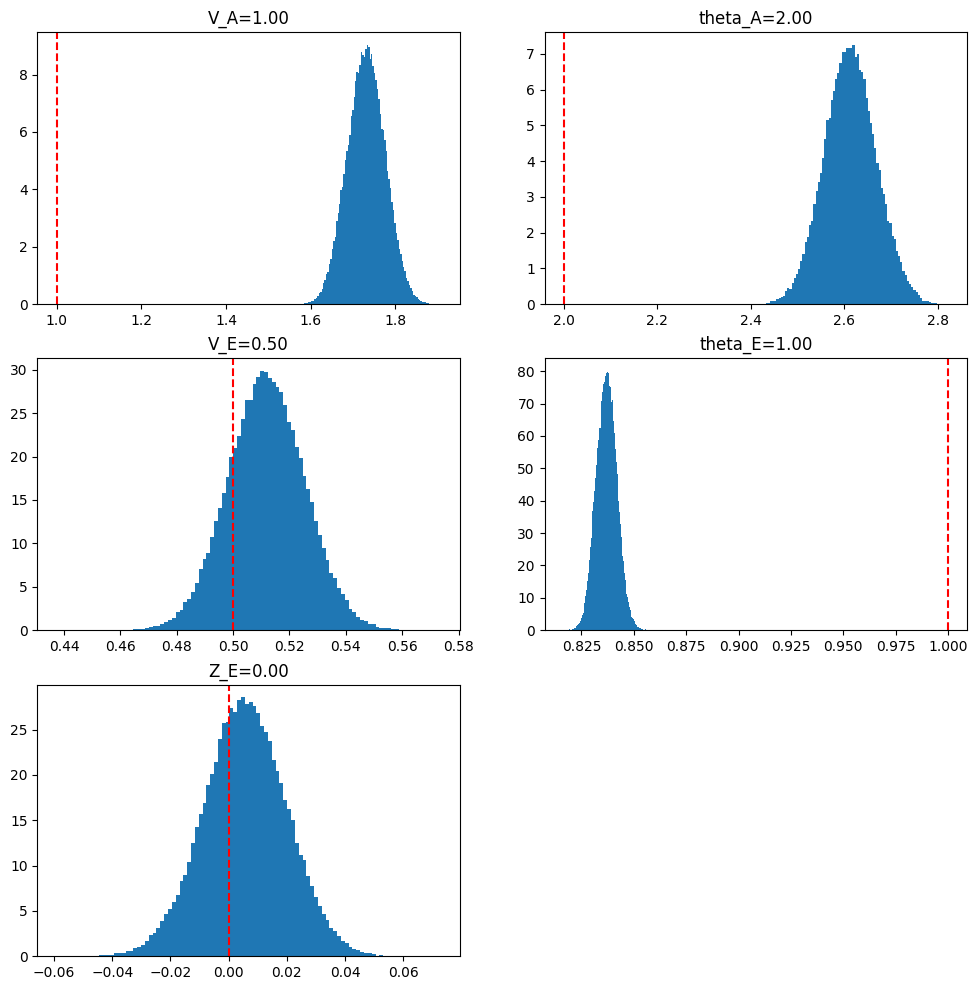

In [33]:
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.hist(vp_samples[:,0], density=True, bins=100);
plt.axvline(x=V_A, color='r', linestyle='--')
plt.title(f'V_A={V_A:.2f}');

plt.subplot(3,2,2)
plt.hist(vp_samples[:,1], density=True, bins=100);
plt.axvline(x=theta_A, color='r', linestyle='--')
plt.title(f'theta_A={theta_A:.2f}');

plt.subplot(3,2,3)
plt.hist(vp_samples[:,2], density=True, bins=100);
plt.axvline(x=V_E, color='r', linestyle='--')
plt.title(f'V_E={V_E:.2f}');


plt.subplot(3,2,4)
plt.hist(vp_samples[:,3], density=True, bins=100);
plt.axvline(x=theta_E, color='r', linestyle='--')
plt.title(f'theta_E={theta_E:.2f}');

plt.subplot(3,2,5)
plt.hist(vp_samples[:,4], density=True, bins=100);
plt.axvline(x=Z_E, color='r', linestyle='--')
plt.title(f'Z_E={Z_E:.2f}');

